# ✨ Hi There

# We're Serial Kernels 🐲

# ✨ Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
from tqdm import tqdm 
import cv2
import os, datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow.keras as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint 

# ✨ Loading Data

In [2]:

train=pd.read_csv('/kaggle/input/arabic-hwr-ai-pro-intake1/train.csv',dtype={'id': str,'label':str})
test=pd.read_csv('/kaggle/input/arabic-hwr-ai-pro-intake1/test.csv',dtype={'id': str})
display(train.head())
print(train.shape)
print(test.shape)
print(train.dtypes)
# train=train.astype(str)
# test=test.astype(str)


,id,label
0,00000,24
1,00001,2
2,00002,17
3,00003,14
4,00004,19


(13440, 2)
(3360, 1)
id       object
label    object
dtype: object


# ✨ Exploring

In [3]:
train.isnull().sum()

id       0
label    0
dtype: int64

In [4]:
train['label'].value_counts()

24    480
2     480
22    480
20    480
3     480
6     480
7     480
5     480
9     480
1     480
25    480
12    480
4     480
26    480
16    480
8     480
15    480
13    480
11    480
21    480
18    480
28    480
23    480
10    480
19    480
14    480
17    480
27    480
Name: label, dtype: int64

In [5]:
X=[]
Y=[]

In [6]:
# def load_data(path):
#     for image in tqdm(os.listdir(path)):
#         image_path = os.path.join(path,image)
#         img = cv2.imread(image_path)
#         X_train.append(np.array(img))
#     return X_train

In [7]:
def load_data(path):
    for image in train['id']:
        image_path = path+image+'.png'
        img = cv2.imread(image_path)
        X.append(np.array(img))
    return X

In [8]:
X=load_data('/kaggle/input/arabic-hwr-ai-pro-intake1/train/')

In [9]:
Y=train['label'].astype(int).tolist()

1

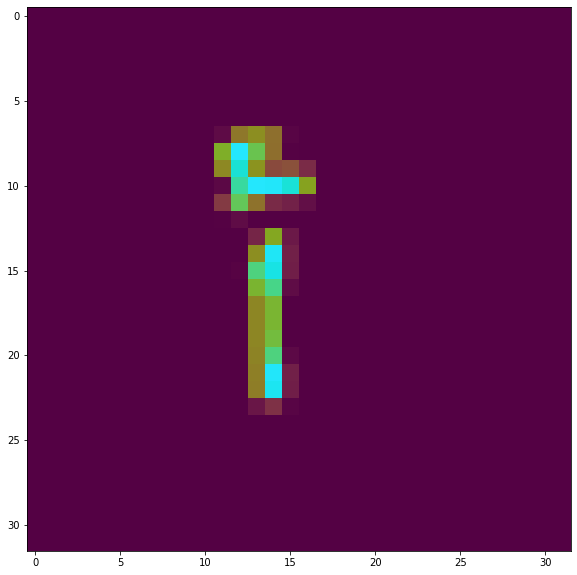

In [10]:
plt.figure(figsize=(10,10))
plt.imshow(X[31])
Y[31]

# ✨ Character Recognition Model

In [11]:
X_train, X_valid, y_train,y_valid = train_test_split(X, Y,test_size=0.33, random_state=0,shuffle=True,stratify=Y)
X_train = np.array(X_train)
y_train = np.array(y_train)
X_valid = np.array(X_valid)

y_valid = np.array(y_valid)

y_train=to_categorical(y_train-1, num_classes=28)
y_valid=to_categorical(y_valid-1, num_classes=28)


input_t = K.Input(shape=(224, 224, 3))
res_model = K.applications.ResNet50(weights='imagenet',include_top=False,input_tensor=input_t)
for layer in res_model.layers[:143]:
        layer.trainable = False

to_res = (224, 224)

model = K.models.Sequential()
model.add(K.layers.Lambda(lambda image: tf.image.resize(image, to_res)))
model.add(res_model)
model.add(K.layers.Flatten())
model.add(K.layers.BatchNormalization())
model.add(K.layers.Dense(256, activation='relu'))
model.add(K.layers.Dropout(0.5))
model.add(K.layers.BatchNormalization())
model.add(K.layers.Dense(128, activation='relu'))
model.add(K.layers.Dropout(0.5))
model.add(K.layers.BatchNormalization())
model.add(K.layers.Dense(64, activation='relu'))
model.add(K.layers.Dropout(0.5))
model.add(K.layers.BatchNormalization())
model.add(K.layers.Dense(28, activation='softmax'))


logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
model.compile(loss='categorical_crossentropy',
              optimizer=K.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0),
              metrics=['accuracy'])

2021-11-07 16:43:08.696479: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-07 16:43:08.790452: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-07 16:43:08.791169: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-07 16:43:08.792230: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

94781440/94765736 [==============================] - 0s 0us/step


/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


# ✨ Data Augmentation

In [12]:
from keras.preprocessing.image import ImageDataGenerator

# create and configure augmented image generator
datagen_train = ImageDataGenerator(
   featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        #rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
# fit augmented image generator on data
datagen_train.fit(X_train)

# ✨ Training

In [13]:
from keras.callbacks import ModelCheckpoint   
from keras.callbacks import ReduceLROnPlateau
batch_size = 64
epochs = 80
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
# train the model
checkpointer = ModelCheckpoint(filepath='weights.hdf5', verbose=1, save_best_only=True)
history=model.fit_generator(datagen_train.flow(X_train,y_train, batch_size=batch_size),
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    epochs=epochs, verbose=2, callbacks=[learning_rate_reduction],
                    validation_data=(X_valid, y_valid))
model.save("model.h5")

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2021-11-07 16:43:14.181878: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
2021-11-07 16:43:19.535916: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/80
140/140 - 32s - loss: 3.0846 - accuracy: 0.1487 - val_loss: 29.2159 - val_accuracy: 0.0636
Epoch 2/80
140/140 - 25s - loss: 1.9203 - accuracy: 0.4281 - val_loss: 2.9893 - val_accuracy: 0.3550
Epoch 3/80
140/140 - 25s - loss: 1.2871 - accuracy: 0.6294 - val_loss: 1.3739 - val_accuracy: 0.6305
Epoch 4/80
140/140 - 25s - loss: 0.9056 - accuracy: 0.7490 - val_loss: 0.4174 - val_accuracy: 0.9044
Epoch 5/80
140/140 - 25s - loss: 0.6982 - accuracy: 0.8179 - val_loss: 0.3128 - val_accuracy: 0.9168
Epoch 6/80
140/140 - 25s - loss: 0.5568 - accuracy: 0.8570 - val_loss: 0.1684 - val_accuracy: 0.9601
Epoch 7/80
140/140 - 25s - loss: 0.4974 - accuracy: 0.8751 - val_loss: 0.2691 - val_accuracy: 0.9243
Epoch 8/80
140/140 - 25s - loss: 0.4313 - accuracy: 0.8921 - val_loss: 0.1429 - val_accuracy: 0.9637
Epoch 9/80
140/140 - 25s - loss: 0.3766 - accuracy: 0.9077 - val_loss: 0.2213 - val_accuracy: 0.9414
Epoch 10/80
140/140 - 25s - loss: 0.3588 - accuracy: 0.9113 - val_loss: 0.2162 - val_accur

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Text(0.5, 1.0, 'Training and validation loss')

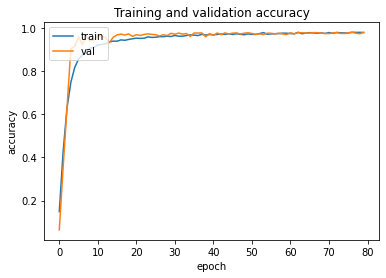

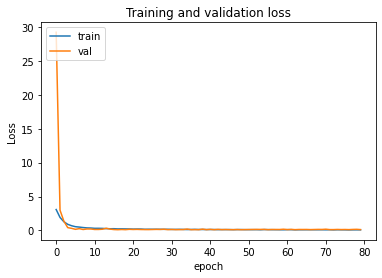

In [14]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.figure()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and validation loss')
plt.legend(['train', 'val'], loc='upper left')
plt.ylabel('Loss')
plt.xlabel('epoch')


plt.title('Training and validation loss')

In [15]:
# %load_ext tensorboard
# %tensorboard --logdir logs
# %reload_ext tensorboard

In [16]:
X=[]

# ✨ Testing

In [17]:
test.head()

,id
0,00000
1,00001
2,00002
3,00003
4,00004


In [18]:
def load_data(path):
    for image in test['id']:
        image_path = path+image+'.png'
        img = cv2.imread(image_path)
        X.append(np.array(img))
    return X

In [19]:
test.head()

,id
0,00000
1,00001
2,00002
3,00003
4,00004


In [20]:
X_test=load_data('/kaggle/input/arabic-hwr-ai-pro-intake1/test/')

In [21]:
X_test=np.array(X_test)

In [22]:
pred=model.predict(X_test)
preds=np.argmax(pred,axis=-1)

In [23]:
test['label']=preds
test['label']=test['label']+1

# ✨ Generating Submission File

In [24]:
test.to_csv('/kaggle/working/submission.csv', index=False)